In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

%matplotlib inline
import warnings
#warnings.filterwarning


## The description of the project
Air pollution is the world’s largest environmental health risk, contributing to 7 million premature deaths globally each year, and poor people in developing countries are the most heavily affected. Low-cost IoT sensor networks on the ground have the potential to close the climate data gaps in sub-Saharan Africa, but networks are expensive to implement and maintain in African cities.
 Satellite-derived PM2.5 estimates based on Aerosol Optical Depth (AOD) and machine learning techniques can be used to estimate pollution levels over large areas to help develop interventions such as vulnerability risk profiles for urban spaces, health preservation and environmental protection for affected populations, as well as community empowerment, and climate change mitigation.

# PROJECT OBJECTIVE
In this challenge, we are asked to estimate PM2.5 levels from satellite observations based on Aerosol Optical Depth (AOD) for eight cities in seven African countries: Lagos, Accra, Nairobi, Yaounde, Bujumbura, Kisumu, Kampala, and Gulu - with varying ground monitoring resolutions, using appropriate machine learning algorithms. Ground-based observations in the selected cities will be used to validate the satellite estimates.

### data loading

In [2]:
# Load files
train_df = pd.read_csv('Dataset.csv')

### data inspection

In [4]:
# Preview the first five rows of the train set
train_df.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7

In [5]:
# Preview the last five rows of the test set
train_df.tail()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
8066,id_ov6ddbfdf0,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-17,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.670265,829684.180938,72.128971,59.979679,-153.374844,21.999478,0.104364,3.020735,0.320225,223.126874,0.880842,72.128971,59.979679,-153.374844,21.999478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.086071
8067,id_3tv6i1a09t,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-24,11,-0.000563,0.595788,-0.000335,0.208774,-98.841057,48.871639,-126.041481,31.948212,-0.000144,1.0,0.034113,2062.178223,1874.310425,830152.187500,-97.119339,48.790192,-126.038307,31.922981,0.000065,0.000034,0.000031,0.000113,7311.869141,-0.200584,0.093810,830186.4375,-98.841057,48.871639,-126.041481,31.948212,0.000116,0.893531,0.000039,0.208774,31.948212,-126.041481,48.871639,-98.841057,-0.200583,830186.437500,-98.841057,48.871639,-126.041481,31.948212,0.106309,2.657948,0.286911,224.778442,0.208584,-98.841057,48.871639,-126.041481,31.948212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.110000
8068,id_csqjqt3f9i,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-25,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.028830,1560.910767,1053.974365,830022.375000,-97.988228,20.025381,-130.718658,28.047552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00015

In [6]:
train_df.shape

(8071, 80)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 80 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

In [8]:
train_df.columns

Index(['id', 'site_id', 'site_latitude', 'site_longitude', 'city', 'country',
       'date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction', 'sulphurdioxide_sensor_azimuth_angle',
       'sulphurdioxide_sensor_zenith_angle',
       'sulphurdioxide_solar_azimuth_angle',
       'sulphurdioxide_solar_zenith_angle',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_densi

In [9]:
train_df.sample(n=10)

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
900,id_rrmfspot18,6353b53377ee57002903db54,0.306112,32.565726,Kampala,Uganda,2023-01-24,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000193,0.726984,-0.000208,0.349556,21.545343,-155.590622,61.877350,71.616318,-0.979376,829269.625000,71.616318,61.877350,-155.590622,21.545343,0.116915,3.101185,0.368270,222.837921,0.350655,71.616318,61.877350,-155.590622,21.545343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.350091,24250.994141,11223.437500,27908.105469,10223.437500,4.130571,0.270340,71.616310,61.877232,-155.590561,21.545368,18.717350
2218,id_7rf7tbmxtp,60d058c8048305120d2d6154,0.344000,32.553000,Kampala,Uganda,2023-12-04,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.270331,829418.062500,72.857877,50.851807,-144.024990,28.307627,0.111692,2.688130,0.305392,227.271386,1.000000,72.857877,50.851807,-144.024990,28.307627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,41985.878906,7363.977051,47465.449219,6363.977051,24.937368,0.333926,72.858215,50.848202,-144.024109,28.308327,60.718100
670,id_a2wfruiz8y,616fe4ce9657420029658b3e,0.405320,32.620270,Kampala,Uganda,2023-03-30,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054298,830206.545973,-97.773657,58.461376,-83.473514,31.651393,0.1

### check for missing values

In [10]:
train_df2=train_df.copy()

In [11]:
train_df2.isna ().mean()*100

id                             0.000000
site_id                        0.000000
site_latitude                  0.000000
site_longitude                 0.000000
city                           0.000000
                                ...    
cloud_sensor_azimuth_angle    38.124148
cloud_sensor_zenith_angle     38.124148
cloud_solar_azimuth_angle     38.124148
cloud_solar_zenith_angle      38.124148
pm2_5                          0.000000
Length: 80, dtype: float64

In [12]:
train_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,8071,8071,id_vjcx08sz91,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
site_id,8071,69,620dd7ce72eb9200299fb8c1,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
site_latitude,8071.0,NaN,NaN,NaN,0.635678,2.154605,-3.45997,0.28863,0.33261,0.374653,6.5954
site_longitude,8071.0,NaN,NaN,NaN,30.246982,9.393151,3.20151,32.568643,32.60048,32.64111,36.914272
city,8071,4,Kampala,5596,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
cloud_sensor_azimuth_angle,4994.0,NaN,NaN,NaN,-18.952179,85.873938,-102.706078,-98.865659,-97.477511,72.814735,77.319656
cloud_sensor_zenith_angle,4994.0,NaN,NaN,NaN,45.88138,14.721454,2.996863,37.901279,49.187592,57.156175,66.238778
cloud_solar_azimuth_angle,4994.0,NaN,NaN,NaN,-84.811978,40.62717,-159.058782,-125.371559,-74.597511,-49.90234,-22.251009
cloud_solar_zenith_angle,4994.0,NaN,NaN,NaN,28.708028,7.038309,10.31499,24.102775,29.002745,33.929767,45.496395


The code above train_df.describe(include="all").T describes the numerical Data as regarding their mean std, min. 25%, 50%, 75% and max values.



The code above shows the correlation between two numerical features. This tells us if there is any relationship between these features in our Dataset. The relatonship could be positive(closer to 1 or 1) or negative(closer to -1 0r -1) or independent(showing no relationship (0)).

In [14]:
Date = ["date", "hour","month"]
Cat=["id","site_id","city","country"]
Categorical=["id","site_id",'site_latitude','site_longitude',"city","country"]
Target= ["pm2_5"]

num= []
for col in train_df.columns:
    if col not in Date + Cat:
        num.append(col)

In [15]:
num

['site_latitude',
 'site_longitude',
 'sulphurdioxide_so2_column_number_density',
 'sulphurdioxide_so2_column_number_density_amf',
 'sulphurdioxide_so2_slant_column_number_density',
 'sulphurdioxide_cloud_fraction',
 'sulphurdioxide_sensor_azimuth_angle',
 'sulphurdioxide_sensor_zenith_angle',
 'sulphurdioxide_solar_azimuth_angle',
 'sulphurdioxide_solar_zenith_angle',
 'sulphurdioxide_so2_column_number_density_15km',
 'carbonmonoxide_co_column_number_density',
 'carbonmonoxide_h2o_column_number_density',
 'carbonmonoxide_cloud_height',
 'carbonmonoxide_sensor_altitude',
 'carbonmonoxide_sensor_azimuth_angle',
 'carbonmonoxide_sensor_zenith_angle',
 'carbonmonoxide_solar_azimuth_angle',
 'carbonmonoxide_solar_zenith_angle',
 'nitrogendioxide_no2_column_number_density',
 'nitrogendioxide_tropospheric_no2_column_number_density',
 'nitrogendioxide_stratospheric_no2_column_number_density',
 'nitrogendioxide_no2_slant_column_number_density',
 'nitrogendioxide_tropopause_pressure',
 'nitroge

In [16]:
for col in train_df2.columns:
    if col in Cat:
        train_df2[Cat]=train_df2[Cat].astype("category")
    elif col in num:
        train_df2[num]=train_df2[num].astype("float64")

In [17]:
train_df2['date'] = pd.to_datetime(train_df2['date'], errors='coerce')
train_df2['hour'] = pd.to_datetime(train_df2['hour'], errors='coerce')
train_df2['month'] = pd.to_datetime(train_df2['hour'], errors='coerce')

train_df2['year'] = pd.DatetimeIndex(train_df2.date).year
train_df2['week'] = pd.DatetimeIndex(train_df2.date).weekday
train_df2['day'] = pd.DatetimeIndex(train_df2.date).day

In [18]:
train_df2

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,year,week,day
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-10-25,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.937500,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,2023,2,25
1,id_bkg215syli,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-02,1970-01-01 00:00:00.000000012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.000000012,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.625000,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,2023,3,2
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-03,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [19]:
train_df2.drop(['date'], axis=1, inplace=True)

In [20]:
train_df3=train_df2.copy()
num2 = num.copy()

In [21]:
for col in num:
    if col not in ['site_latitude', 'site_longitude']:
        train_df3[col] = train_df3[col].abs()

In [22]:
train_df3

,id,site_id,site_latitude,site_longitude,city,country,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,year,week,day
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.937500,100.805145,21.720518,123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,100.805145,21.720518,123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,2023,2,25
1,id_bkg215syli,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,1970-01-01 00:00:00.000000012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.000000012,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,143.480164,59.220097,70.875954,0.315206,828578.625000,70.875954,59.220097,143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,2023,3,2
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.000000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.687500,96.411942,

##As given in the instruction for the project, the PM2_5 cap is 180

In [23]:
train_df3.loc[train_df3['pm2_5']>180, 'pm2_5']=180

In [24]:
train_df4 = train_df3.copy()

##Remove columns that contains over 90% missing values and above


In [25]:
Threshold = 90

missing_values = train_df4.isna().mean()*100

columns_to_drop = missing_values[missing_values > Threshold].index

train_df4.drop(columns=columns_to_drop, inplace=True)

In [26]:
train_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   id                                                        8071 non-null   category      
 1   site_id                                                   8071 non-null   category      
 2   site_latitude                                             8071 non-null   float64       
 3   site_longitude                                            8071 non-null   float64       
 4   city                                                      8071 non-null   category      
 5   country                                                   8071 non-null   category      
 6   hour                                                      8071 non-null   datetime64[ns]
 7   sulphurdioxide_so2_column_number_density  

##Convert the year, the week and the day to Datetime format

In [27]:
train_df4['year'] = pd.to_datetime(train_df4['year'], errors='coerce')
train_df4['week'] = pd.to_datetime(train_df4['week'], errors='coerce')
train_df4['day'] = pd.to_datetime(train_df4['day'], errors='coerce')

In [28]:
train_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   id                                                        8071 non-null   category      
 1   site_id                                                   8071 non-null   category      
 2   site_latitude                                             8071 non-null   float64       
 3   site_longitude                                            8071 non-null   float64       
 4   city                                                      8071 non-null   category      
 5   country                                                   8071 non-null   category      
 6   hour                                                      8071 non-null   datetime64[ns]
 7   sulphurdioxide_so2_column_number_density  

##REFERENCE INFORMATION
Sulphur Dioxide (SO:), Nitrogen Dioxide (NO.), and Carbon Monoxide (CO) columns are very important indicators because they play a major role in atmospheric concitions that impact FM2.5 dispersion and persistence. Hence, the three columns can't be dropped it we are to make correct pm2.5 predictions

Reference link
Sulphur Dioxide (SO.)

Crucial for assessing respiratory impacts and acid rain formation
Nitrogen Dioxide (NO:)

Indicator of traffic pollution, linked to respiratory diseases and PM? 5 formation
Carbon Monoxide (CO):

Hamful at nigh concentrations, indicates incomplete combustion.

### Handle Missing Values¶
 

##### Sensitivity and Variability

* Pollutant levels vary greaty with environmental changes, making precise data essental
* Imputing with means tor large volume of missing values can distort this variability and misrepresent trends.
* In that case Advanced Imputation like Interpolation is needed
* Interpolation methods use existing data points surrounding the missing values to estimate what the value might be if it were observed.

In [29]:
train_df5= train_df4.copy()

In [30]:
#Numerical colums
numerical_cols = train_df5.select_dtypes(include=['float64', 'Int64']).columns
                                                  
#Replocing missing values through interpolation
train_df5[numerical_cols]= train_df5[numerical_cols].interpolate(method='linear', axis=0)

#Selecting non-numerical colums
non_numerical_cols = train_df5.select_dtypes(exclude = ['float64', 'Int64']).columns

In [31]:
# fill the missing volues in non-numerical columns with the mode (most frequent value)

for col in non_numerical_cols:
    train_df5[col].fillna(train_df5[col].mode()[0], inplace=True)

#Verifying if missing values have been handled 
train_df5.isnull().sum().sort_values(ascending=False)

nitrogendioxide_stratospheric_no2_column_number_density    4
sulphurdioxide_sensor_azimuth_angle                        4
nitrogendioxide_no2_slant_column_number_density            4
nitrogendioxide_tropopause_pressure                        4
nitrogendioxide_absorbing_aerosol_index                    4
                                                          ..
uvaerosolindex_solar_zenith_angle                          0
ozone_o3_column_number_density                             0
ozone_o3_column_number_density_amf                         0
ozone_o3_slant_column_number_density                       0
day                                                        0
Length: 75, dtype: int64

Since the maximum number of missing values found in any of the columns is now 4, we can now make use of mean to fill it in¶

In [32]:
#FiLL missing values in numerical colums with mean
train_df5[numerical_cols]= train_df5[numerical_cols].fillna(train_df5[numerical_cols].mean())

#Verify that missing values have been handled
train_df5.isnull().sum().sort_values(ascending=False)

id                                      0
ozone_sensor_azimuth_angle              0
ozone_o3_effective_temperature          0
ozone_o3_slant_column_number_density    0
ozone_o3_column_number_density_amf      0
                                       ..
carbonmonoxide_solar_zenith_angle       0
carbonmonoxide_solar_azimuth_angle      0
carbonmonoxide_sensor_zenith_angle      0
carbonmonoxide_sensor_azimuth_angle     0
day                                     0
Length: 75, dtype: int64

In [33]:
train_df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   id                                                        8071 non-null   category      
 1   site_id                                                   8071 non-null   category      
 2   site_latitude                                             8071 non-null   float64       
 3   site_longitude                                            8071 non-null   float64       
 4   city                                                      8071 non-null   category      
 5   country                                                   8071 non-null   category      
 6   hour                                                      8071 non-null   datetime64[ns]
 7   sulphurdioxide_so2_column_number_density  

In [34]:
train_df6 = train_df5[numerical_cols]

In [35]:
train_df6.head()

,site_latitude,site_longitude,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.034576,2249.146062,2101.711420,829577.635925,82.102012,38.534061,89.330355,28.304600,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000183,1.071280,0.000139,0.203980,27.614336,89.525189,40.438103,84.921997,0.052301,828817.9375,100.805145,21.720518,123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,100.805145,21.720518,123.523796,33.745914,0.565651,52053.256026,6054.152723,58691.919068,5071.351870,16.268318,0.251779,86.934775,45.433655,88.501771,28.692221,12.015000
1,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,143.370575,26.566997,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000214,1.462390,0.000240,0.359150,26.525513,143.480164,59.220097,70.875954,0.315206,828578.6250,70.875954,59.220097,143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,143.480164,26.525513,0.565651,52053.256026,6054.152723,58691.919068,5071.351870,16.268318,0.251779,86.934775,45.433655,88.501771,28.692221,42.267200
2,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.046665,3685.365491,2825.961389,828680.679354,78.196780,55.917395,137.603966,31.092726,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000176,1.407738,0.000183,0.313901,31.072787,137.674932,55.984512,79.854383,1.097816,828878.6875,96.411942,61.045010,121.307121,41.898113,0.117559,3.248

In [36]:
train_df7 = train_df5 [non_numerical_cols]

In [37]:
train_df7.head()

,id,site_id,city,country,hour,month,year,week,day
0,id_vjcx08sz91,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000025
1,id_bkg215syli,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000002
2,id_oui2pot3qd,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000004,1970-01-01 00:00:00.000000003
3,id_9aandqzy4n,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000014,1970-01-01 00:00:00.000000014,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000008
4,id_ali5x2m4iw,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000009


## EXPLORATORY DATA ANALYSIS (EDA)

In [38]:
train_df5.describe().T

,count,mean,min,25%,50%,75%,max,std
site_latitude,8071.0,0.635678,-3.45997,0.28863,0.33261,0.374653,6.5954,2.154605
site_longitude,8071.0,30.246982,3.20151,32.568643,32.60048,32.64111,36.914272,9.393151
hour,8071,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000011,1970-01-01 00:00:00.000000011,1970-01-01 00:00:00.000000014,NaN
sulphurdioxide_so2_column_number_density,8071.0,0.000262,0.0,0.000115,0.000221,0.000352,0.002024,0.000204
sulphurdioxide_so2_column_number_density_amf,8071.0,0.701246,0.299364,0.615469,0.693799,0.7718,1.607052,0.127801
...,...,...,...,...,...,...,...,...
cloud_solar_zenith_angle,8071.0,28.692221,10.31499,24.545569,28.742159,33.185845,45.496395,6.386583
pm2_5,8071.0,24.154609,1.2,13.2706,18.3754,28.8384,180.0,19.792712
year,8071,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000002024,NaN
week,8071,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000005,1970-01-01 00:00:00.000000006,NaN


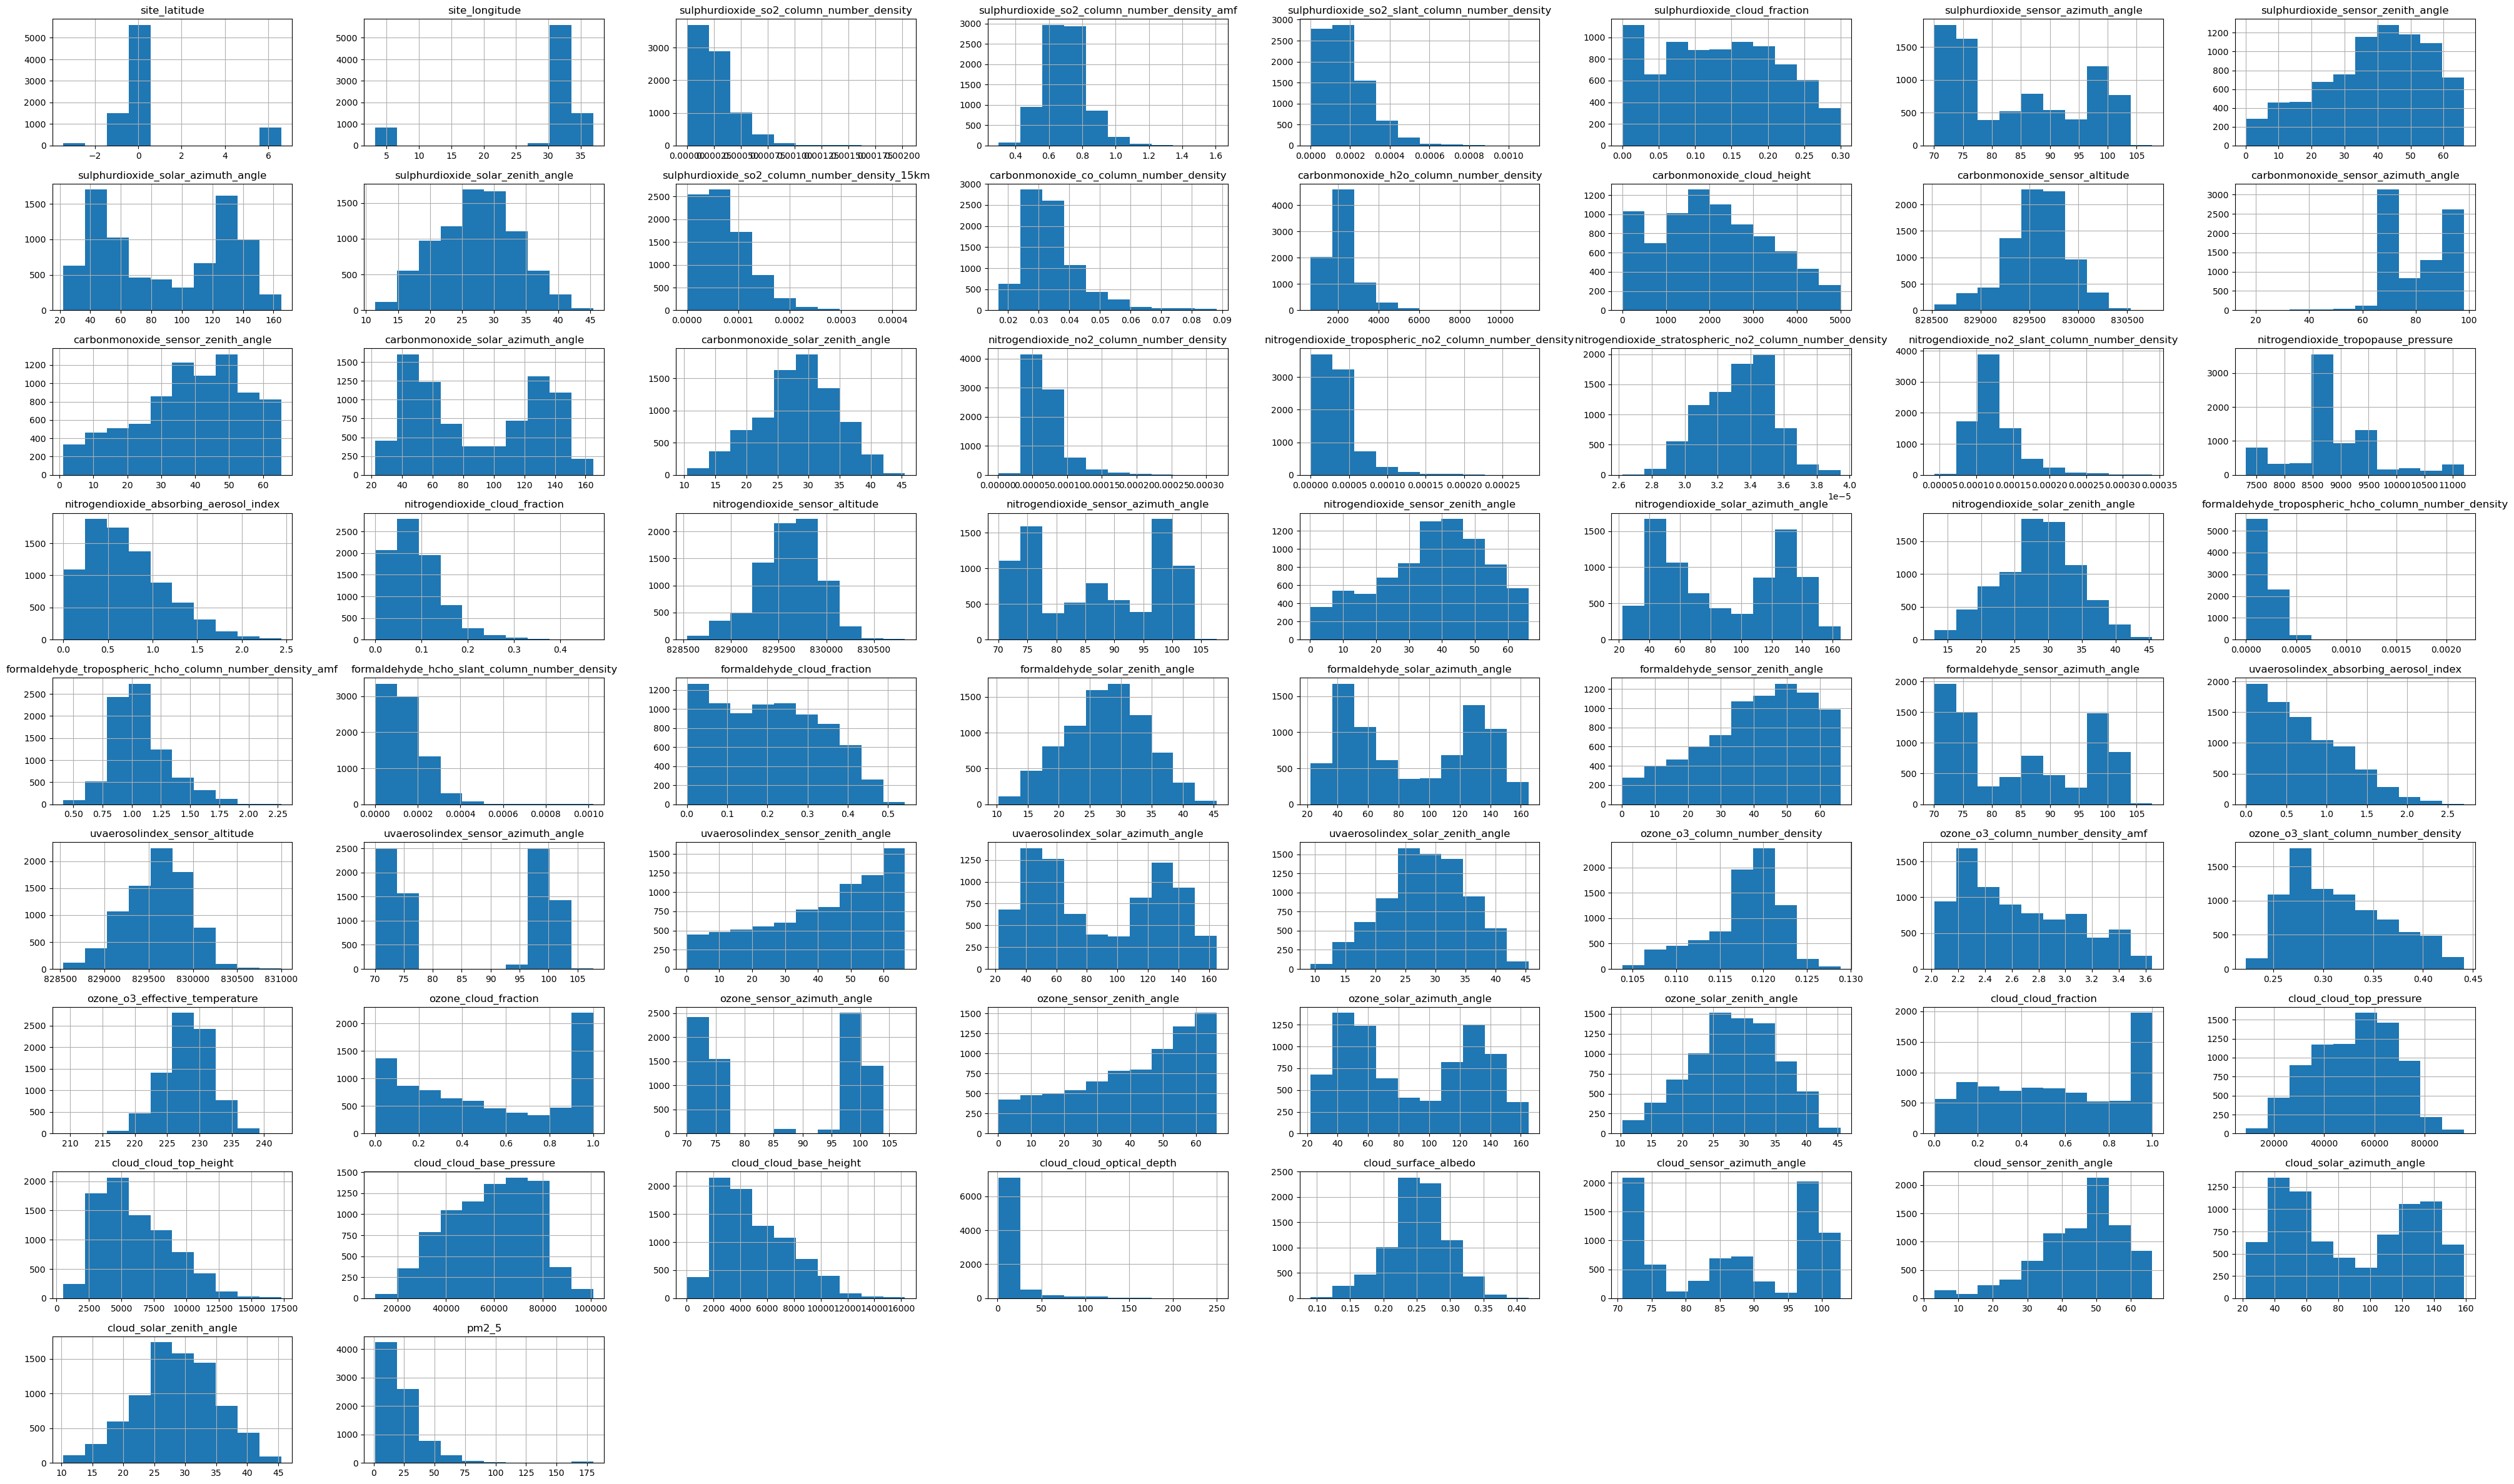

In [39]:
train_df6.hist(figsize=(50,30))
plt.show()

In [40]:
train_df6.corr()

,site_latitude,site_longitude,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
site_latitude,1.000000,-0.962193,0.036366,-0.074930,-0.008747,0.037427,0.031344,0.030773,0.319003,0.193861,-0.035497,0.660949,0.409032,-0.078440,-0.673634,0.020882,0.019203,0.307122,0.116731,0.604848,0.591704,0.088642,0.581586,-0.161758,0.051908,0.019550,-0.664280,0.000385,0.034632,0.320469,0.177959,0.169667,0.015690,0.203827,-0.012481,0.167620,0.303087,0.027935,0.026970,0.058839,-0.628591,-0.018842,0.009461,0.296505,0.095197,0.075943,0.027528,0.042973,0.076960,-0.110418,-0.020331,0.010108,0.297894,0.094985,-0.178807,0.082431,-0.061492,0.081745,-0.061771,-0.038048,-0.357856,-0.045957,0.111432,0.284375,0.118668,0.319635
site_longitude,-0.962193,1.000000,-0.034562,0.074330,0.014701,-0.042098,-0.012125,-0.048977,-0.358829,-0.208358,0.043616,-0.672035,-0.390094,0.079363,0.643825,-0.014514,-0.052377,-0.348969,-0.133557,-0.637987,-0.625098,-0.050237,-0.633483,0.178338,-0.073172,-0.063774,0.635157,0.014792,-0.068282,-0.359574,-0.199951,-0.161839,-0.042104,-0.203959,-0.013176,-0.196273,-0.341700,-0.050093,-0.019335,-0.065293,0.576595,0.020406,-0.012692,-0.332823,-0.128205,-0.025171,-0.044366,-0.047117,-0.108237,0.103516,0.023068,-0.013878,-0.334508,-0.126958,0.184084,-0.127185,0.103731,-0.126665,0.104132,0.046091,0.419027,0.056178,-0.095512,-0.325698,-0.147892,-0.338030
sulphurdioxide_so2_column_number_density,0.036366,-0.034562,1.000000,-0.294805,0.945447,0.001506,-0.074952,0.182947,0.022452,-0.056901,0.884742,0.087889,-0.057422,-0.023681,-0.036229,-0.018532,0.082925,0.031100,-0.032491,0.011940,0.020535,-0.075596,0.071425,0.005997,0.035048,0.005757,-0.032747,-0.004478,0.079118,0.025158,-0.020879,0.076194,-0.129837,0.046750,-0.025227,-0.065001,0.022158,0.139824,-0.074492,0.042024,-0.029980,-0.031281,0.094587,0.020428,-0.035379,0.037607,0.114738,0.121253,-0.041544,0.002226,-

<Figure size 1000x1000 with 0 Axes>

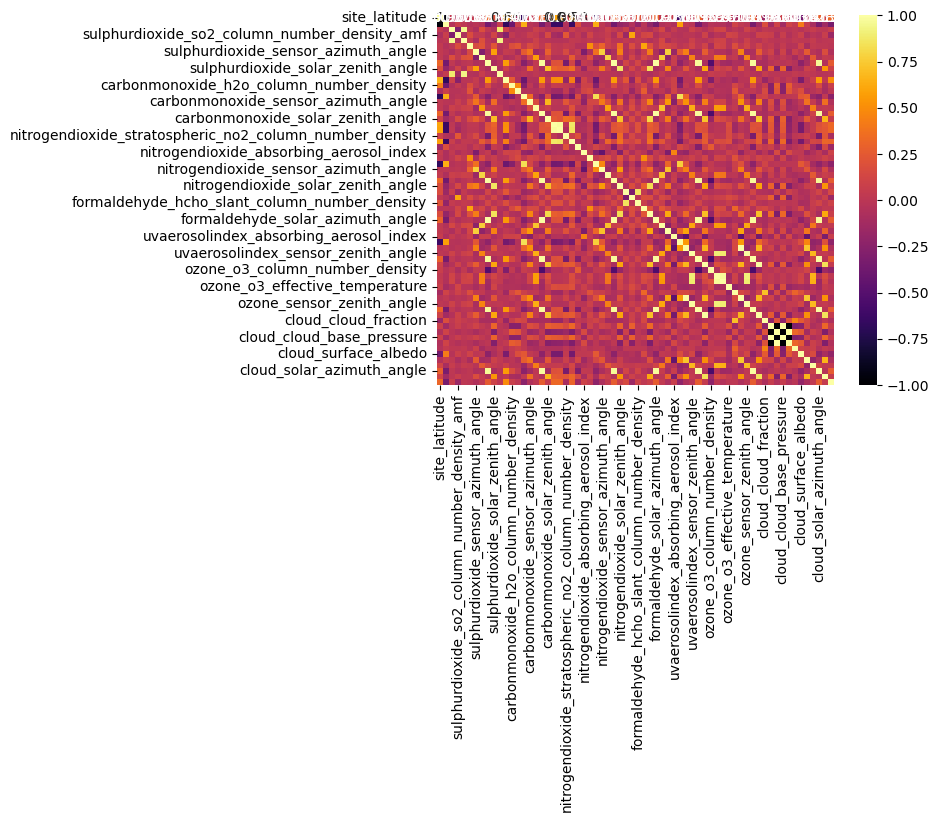

<Figure size 1000x1000 with 0 Axes>

In [43]:
# Correlation Heatmap
Cor=train_df6.corr()

sns.heatmap(data=Cor, vmin=-1, vmax=1, annot=True, cmap="inferno");
plt.figure(figsize=(10,10))

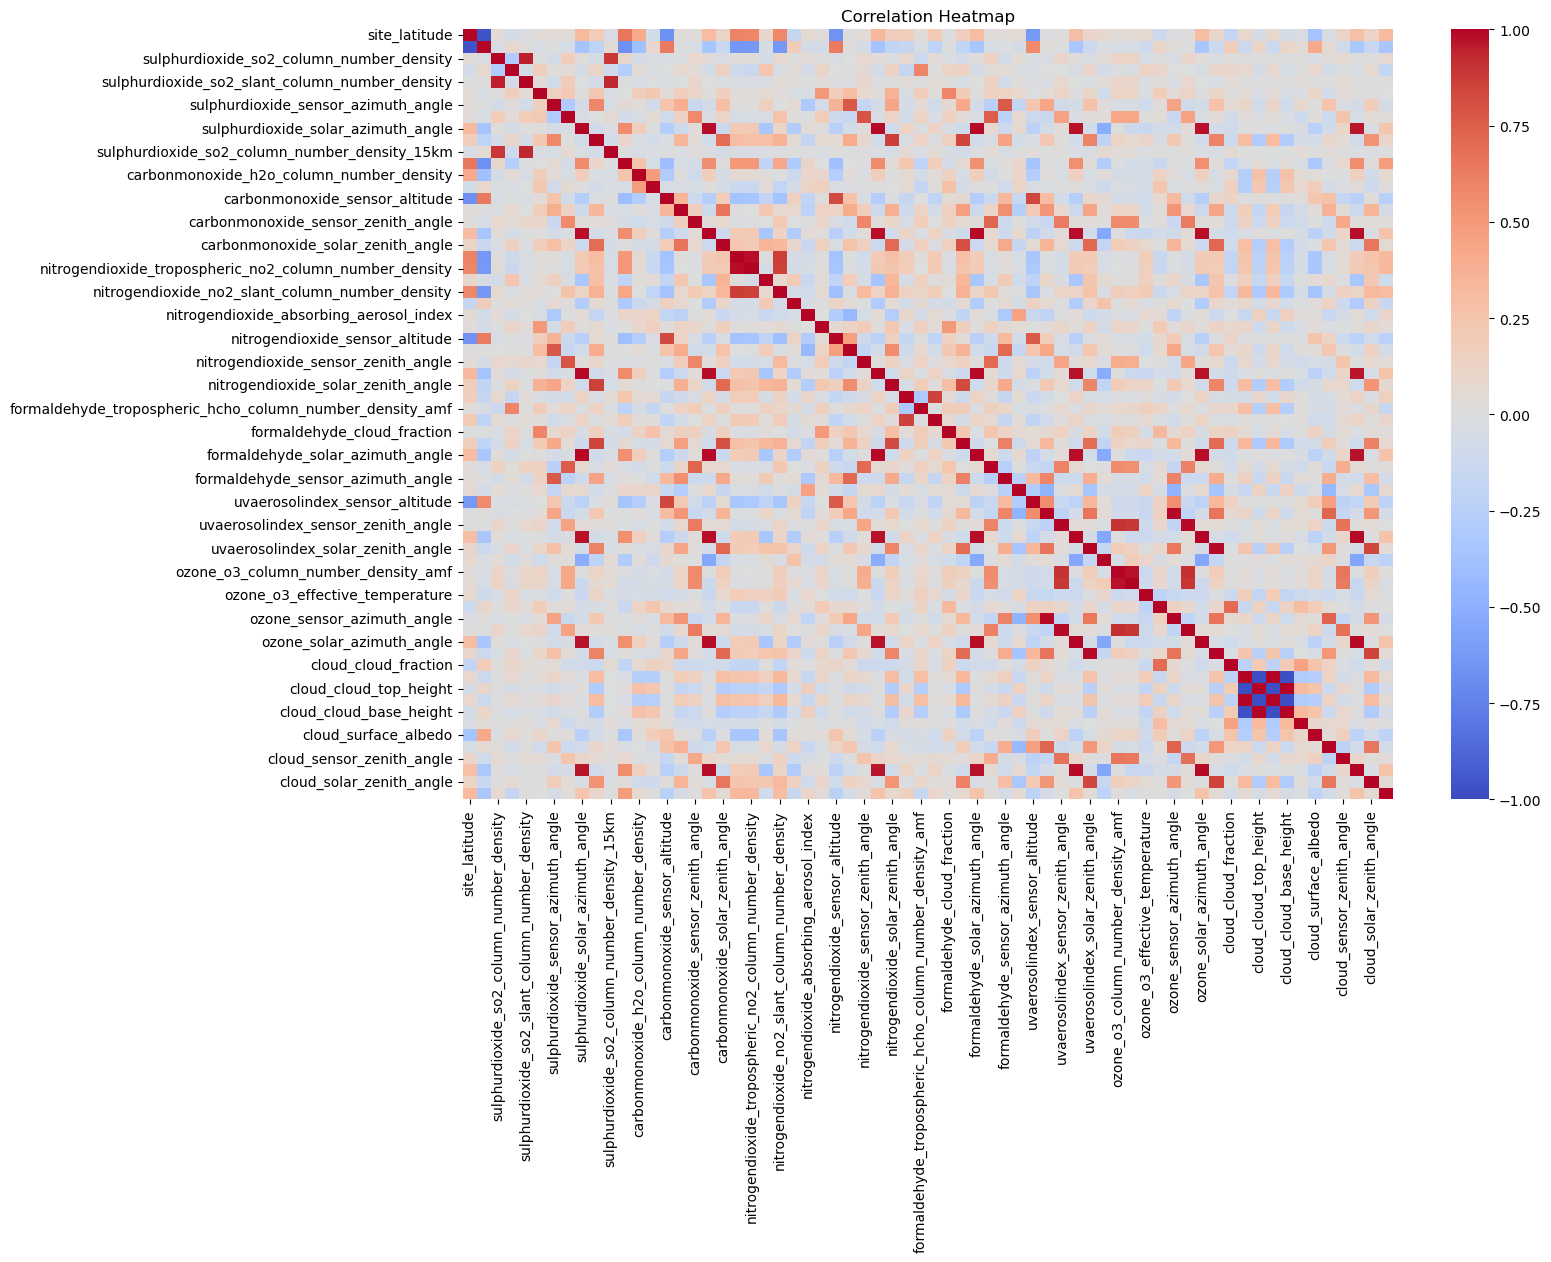

In [44]:
# Correlation Heatmap
cor = train_df6.corr()
plt.figure(figsize=(15,10))
sns.heatmap(data=Cor, vmin=-1, vmax=1, annot=False, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


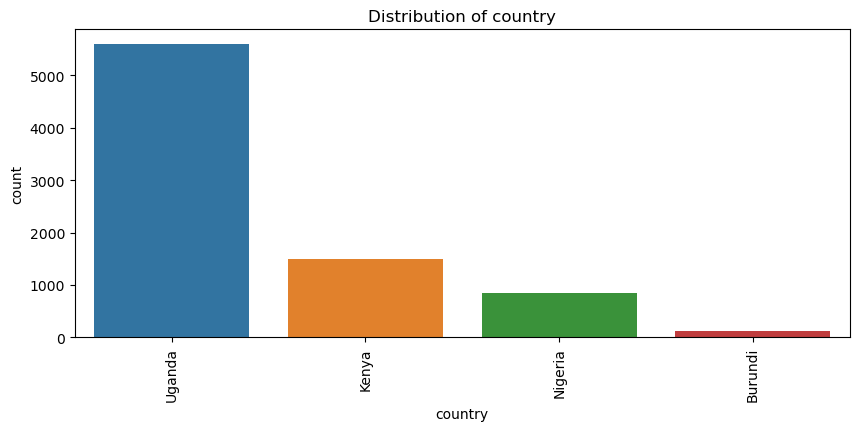

C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


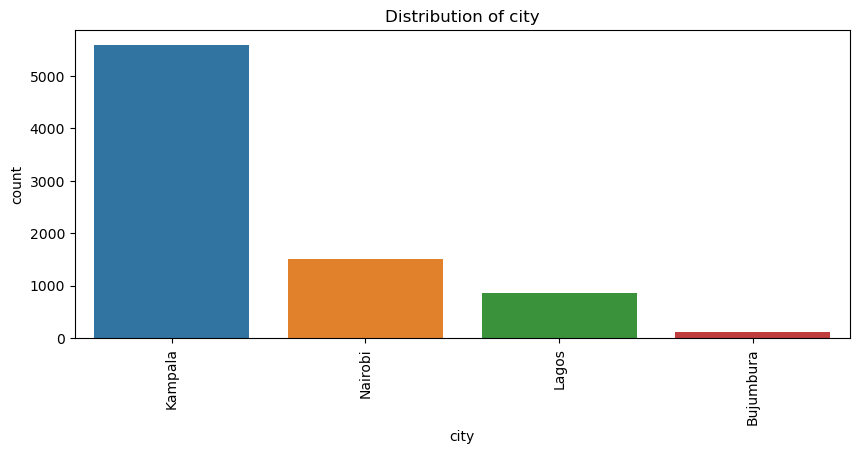

In [78]:
cat_columns = ['country', 'city']
for col in cat_columns:
    plt.figure(figsize=(10,4))
    sns.countplot(x=col, data=train_df7, order=train_df7[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

In [77]:
import folium

# Filter data for Africa based on latitude and longitude ranges
 train_df = [(df['site_latitude'] >= -34.0) & (df['site_latitude'] <= 37.0) 
                    (df['site_longitude'] >= -17.0) & (df['site_longitude'] <= 51.0)]

# Check if the filtered data is not empty
if data_df_africa.empty:
    print("No data available for the specified latitude and longitude ranges.")
else:
    # Create a base map centered around the mean latitude and longitude of the filtered data
    map_center = [train_df_africa['site_latitude'].mean(), train_df_africa['site_longitude'].mean()]
    n = folium.Map(location=map_center, zoom_start=4)

    # Add markers to the map
    for key, row in train_df_africa.iterrows():
        folium.CircleMarker(
            location=[row['site_latitude'], row['site_longitude']],
            radius=20,
            popup=f"PM2.5: {row['pm2_5']}",
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(n)
    
    # Save the map as an HTML file
    n.save('pm2_5_map.html')
    print("Map saved successfully as pm2_5_map.html")


IndentationError: unexpected indent (2972474208.py, line 4)

## Feature Engineering 

In [48]:
train_df8= pd.concat([train_df6, train_df7], axis = 1)

In [49]:
train_df8.head()

,site_latitude,site_longitude,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,id,site_id,city,country,hour,month,year,week,day
0,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.034576,2249.146062,2101.711420,829577.635925,82.102012,38.534061,89.330355,28.304600,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000183,1.071280,0.000139,0.203980,27.614336,89.525189,40.438103,84.921997,0.052301,828817.9375,100.805145,21.720518,123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,100.805145,21.720518,123.523796,33.745914,0.565651,52053.256026,6054.152723,58691.919068,5071.351870,16.268318,0.251779,86.934775,45.433655,88.501771,28.692221,12.015000,id_vjcx08sz91,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000025
1,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,143.370575,26.566997,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000214,1.462390,0.000240,0.359150,26.525513,143.480164,59.220097,70.875954,0.315206,828578.6250,70.875954,59.220097,143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,143.480164,26.525513,0.565651,52053.256026,6054.152723,58691.919068,5071.351870,16.268318,0.251779,86.934775,45.433655,88.501771,28.692221,42.267200,id_bkg215syli,6531a46a89b3300013914a36,Lagos,Nigeria,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000002
2,6.53257

In [50]:
train_df9 = train_df8.drop(columns=['id','site_id'])

### Dealing with Categorical Variables

In [51]:
cat_1 = ['city', 'country']

train_df10 = pd.get_dummies(train_df9, columns=cat_1, drop_first = True)

In [52]:
train_df10.head()

,site_latitude,site_longitude,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,hour,month,year,week,day,city_Kampala,city_Lagos,city_Nairobi,country_Kenya,country_Nigeria,country_Uganda
0,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.034576,2249.146062,2101.711420,829577.635925,82.102012,38.534061,89.330355,28.304600,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000183,1.071280,0.000139,0.203980,27.614336,89.525189,40.438103,84.921997,0.052301,828817.9375,100.805145,21.720518,123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,100.805145,21.720518,123.523796,33.745914,0.565651,52053.256026,6054.152723,58691.919068,5071.351870,16.268318,0.251779,86.934775,45.433655,88.501771,28.692221,12.015000,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000000013,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000025,False,True,False,False,True,False
1,6.53257,3.39936,0.000262,0.701246,0.000174,0.133458,84.493954,39.037141,89.321801,27.286665,0.000073,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,143.370575,26.566997,0.000070,0.000037,0.000033,0.000125,8855.760493,0.705165,0.088033,829608.136645,87.071061,37.038540,89.263919,28.513742,0.000214,1.462390,0.000240,0.359150,26.525513,143.480164,59.220097,70.875954,0.315206,828578.6250,70.875954,59.220097,143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,143.480164,26.525513,0.565651,52053.256026,6054.152723,58691.919068,5071.351870,16.268318,0.251779,86.934775,45.433655,88.501771,28.692221,42.267200,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000000012,1970-01-01 00:00:00.000002023,1970-01-01 00:00:00.000000003,1970-01-01 00:00:00.000000002,False,True,False,False,

In [53]:
# Split the Data
X = train_df10.drop(columns=['pm2_5','hour','month','year', 'week', 'day'])
y = train_df10['pm2_5']

#### FEATURE SCALING

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_1 = scaler.fit_transform(X)

In [56]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np



# Define features and target
X = train_df10.drop(columns=['pm2_5','hour','month','year', 'week', 'day'])
y = train_df10['pm2_5']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 275.976930425506
R^2 Score: 0.29776023211790303


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=7,
        min_samples_split=2,
        min_samples_leaf=4,
        subsample=1.0,
        random_state=42
    )
}

# Train, predict, and calculate RMSE for each model
rmse_values = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values[model_name] = rmse

# Print the RMSE values for each model
for model_name, rmse in rmse_values.items():
    print(f'{model_name}: RMSE = {rmse:.4f}')


Decision Tree: RMSE = 19.2046
Random Forest: RMSE = 13.8423
Gradient Boosting: RMSE = 11.1594


## Model Comparison

In [57]:
yPredict = pd.DataFrame( {"actual": y_test, 
'predicted': y_pred })
yPredict.head()

,actual,predicted
742,18.009200,18.019024
2127,28.199700,26.722149
2107,19.466667,28.917462
2943,47.629700,41.003399
6691,41.196300,41.003399
